# Localize flying fish by RSSI in 2D

In [1]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## RSSI vs distance

http://electronics.stackexchange.com/questions/83354/calculate-distance-from-rssi

In [2]:
def dist_to_rssi(d, a, n=2.7):
    """
    Compute rssi of an emitter given a distance
    
    rssi = -10 * n * log10(d) + A
    or
    d = 10^ ( -(rssi - A) / (10 * n))
    
    :param d: distance from emitter
    :param n: propagation constant or path-loss exponent i.e. 2.7 to 4.3 (Free space has n =2 for reference)
    :param a: received signal strength in dBm at 1 meter
    
    http://electronics.stackexchange.com/questions/83354/calculate-distance-from-rssi
    """    
    return -10 * n * np.log(d)/np.log(10) + a

In [3]:
def rssi_to_dist(s, a, n=2.7):
    """
    Compute distance to an emitter given RSSI
    
    rssi = -10 * n * log10(d) + A
    
    d = 10^ ( -(rssi - A) / (10 * n))
    
    :param s: RSSI in dBm
    :param n: propagation constant or path-loss exponent i.e. 2.7 to 4.3 (Free space has n =2 for reference)
    :param a: received signal strength in dBm at 1 meter
    
    http://electronics.stackexchange.com/questions/83354/calculate-distance-from-rssi
    """    
    return np.power(10.0, -0.1 * (s - a) / n)

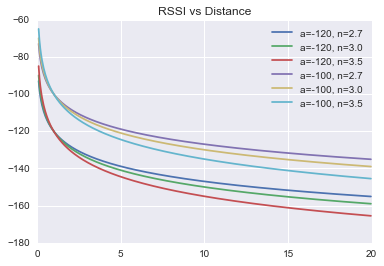

In [4]:
x = np.arange(0.10, 20.0, 0.05)
plt.plot(x, dist_to_rssi(x, a=-120, n=2.7), label='a=-120, n=2.7')
plt.plot(x, dist_to_rssi(x, a=-120, n=3.0), label='a=-120, n=3.0')
plt.plot(x, dist_to_rssi(x, a=-120, n=3.5), label='a=-120, n=3.5')
plt.plot(x, dist_to_rssi(x, a=-100, n=2.7), label='a=-100, n=2.7')
plt.plot(x, dist_to_rssi(x, a=-100, n=3.0), label='a=-100, n=3.0')
plt.plot(x, dist_to_rssi(x, a=-100, n=3.5), label='a=-100, n=3.5')
plt.title('RSSI vs Distance')
plt.legend()

In [5]:
def points_2d_from_rssi(s, rssi_to_dist_f, beacon_pos=(0.0,0.0)):
    d = rssi_to_dist_f(s)
    angles = np.arange(0.0, 360.0, 1.0)
    pts = np.zeros((len(angles), 2))
    pts[:, 0] = beacon_pos[0] + d * np.cos(angles)
    pts[:, 1] = beacon_pos[1] + d * np.sin(angles)
    return pts

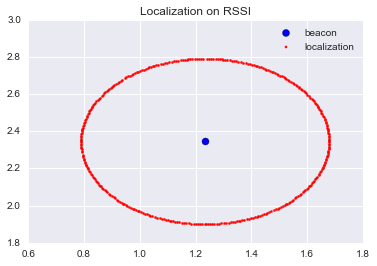

In [6]:
beacon_pos = (1.234, 2.345)
pts = points_2d_from_rssi(-110.5, lambda s: rssi_to_dist(s, a=-120), beacon_pos)
plt.title("Localization on RSSI")
plt.scatter(beacon_pos[0], beacon_pos[1], s=50, label='beacon')
plt.scatter(pts[:,0], pts[:,1], color='r', s=5, label='localization')
plt.legend()

## Multiple beacon case

In [7]:
beacon_positions = np.array([
    [-12.34, 0.0],
    [-2.345, 5.67],
    [3.456, 6.789],
    [13.456, 1.234],
])

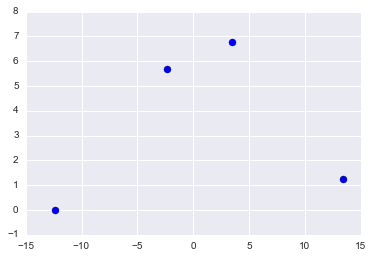

In [8]:
plt.scatter(beacon_positions[:, 0], beacon_positions[:, 1], s=50)

In [9]:
signals = np.array([
    -150,
    -141,
    -140,
    -148
])
rssi_to_dist_f_list = [
    lambda s: rssi_to_dist(s, a=-120),
    lambda s: rssi_to_dist(s, a=-120),
    lambda s: rssi_to_dist(s, a=-120),
    lambda s: rssi_to_dist(s, a=-120), 
]

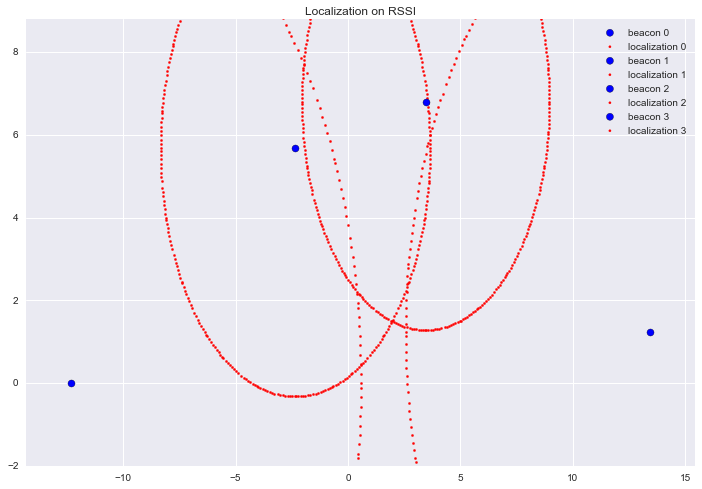

In [11]:
plt.figure(figsize=(12, 8))
for i, s in enumerate(signals):
    beacon_pos = beacon_positions[i]
    pts = points_2d_from_rssi(s, rssi_to_dist_f_list[i], beacon_pos)
    plt.title("Localization on RSSI")
    plt.scatter(beacon_pos[0], beacon_pos[1], s=50, label='beacon %i' % i)
    plt.scatter(pts[:,0], pts[:,1], color='r', s=5, label='localization %i' % i)
plt.legend()
plt.xlim(np.min(beacon_positions[:,0]) - 2.0, np.max(beacon_positions[:,0]) + 2.0)
_ = plt.ylim(np.min(beacon_positions[:,1]) - 2.0, np.max(beacon_positions[:,1]) + 2.0)

In [12]:
def compute_position(signals, rssi_to_dist_f_list, beacon_positions, gamma=0.01, init_pos=(0.0, 0.0), n=100, verbose=0):
    """
    Method to compute localization on received signal
    
    p <- p - gamma * sum_i( p - estimated_positions[i])
    estimated_positions[i, j] = rssi_to_dist_f_list[i](signals[i]) * unit_vector(p[j] - beacon_positions[i, j]) + beacon_positions[i, j] 
    where i goes over beacons, j is [0, 1]   
    """
    assert len(signals) == len(rssi_to_dist_f_list) == len(beacon_positions), "WTF"
    
    def _unit_vector(v):
        return v / np.linalg.norm(v)
    
    distances = [rssi_to_dist_f_list[i](signals[i]) for i in range(len(signals))]
    
    def _update_estimated_positions(estimated_positions, p):
        for i in range(len(estimated_positions)):
            d = distances[i]
            uv = _unit_vector(p - beacon_positions[i, :])
            estimated_positions[i, :] = d * uv + beacon_positions[i, :]
        
    p = list(init_pos)
    estimated_positions = np.zeros((len(signals), 2))
    if verbose > 0:
        print "- Initial position, ", p
    for i in range(n):
        _update_estimated_positions(estimated_positions, p)
        p[0] -= gamma * np.sum(p[0] - estimated_positions[:, 0])
        p[1] -= gamma * np.sum(p[1] - estimated_positions[:, 1])        
        if verbose > 1:
            print i, "-- Update ", p    
    if verbose > 0:
        print "- Computed ", p
    return p

In [16]:
p = compute_position(signals, rssi_to_dist_f_list, beacon_positions, gamma=0.1, n=100, verbose=2)
p

- Initial position,  [0.0, 0.0]
0 -- Update  [0.40916012417912961, 0.22529893096592812]
1 -- Update  [0.71258040209899065, 0.40910795301078928]
2 -- Update  [0.93819020835496392, 0.56086915201424392]
3 -- Update  [1.1063321409763516, 0.68716885685919959]
4 -- Update  [1.2319369782362988, 0.792824357836166]
5 -- Update  [1.3259988138758321, 0.88150530717248832]
6 -- Update  [1.3966265829316105, 0.95609699090293021]
7 -- Update  [1.4498091939774433, 1.0189212300545192]
8 -- Update  [1.4899761250330532, 1.0718772220768589]
9 -- Update  [1.5204088654573855, 1.1165359796677308]
10 -- Update  [1.5435429590110847, 1.1542068631342004]
11 -- Update  [1.5611897720257131, 1.185986602164776]
12 -- Update  [1.5746994068664317, 1.2127968059065857]
13 -- Update  [1.5850804930485691, 1.2354135322816953]
14 -- Update  [1.5930883843615531, 1.2544911220548809]
15 -- Update  [1.5992901953869982, 1.2705817189380821]
16 -- Update  [1.604112842010925, 1.284151434836569]
17 -- Update  [1.6078785925291026, 1.2

[1.6226472387400181, 1.3569084512885359]

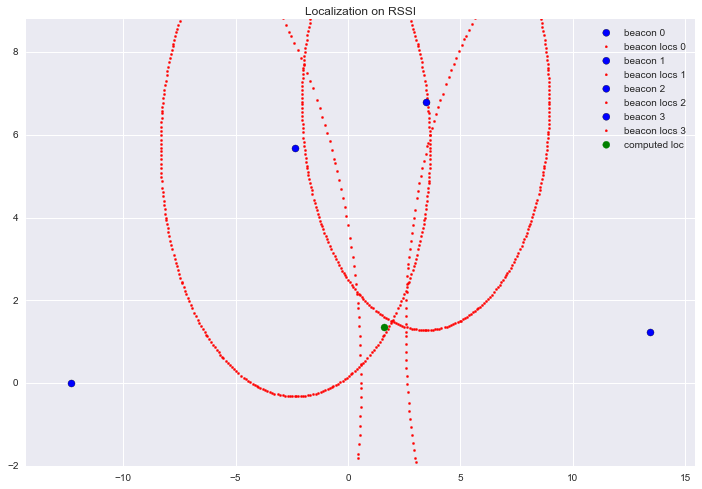

In [17]:
plt.figure(figsize=(12, 8))
for i, s in enumerate(signals):
    beacon_pos = beacon_positions[i]
    pts = points_2d_from_rssi(s, rssi_to_dist_f_list[i], beacon_pos)
    plt.title("Localization on RSSI")
    plt.scatter(beacon_pos[0], beacon_pos[1], s=50, label='beacon %i' % i)
    plt.scatter(pts[:,0], pts[:,1], color='r', s=5, label='beacon locs %i' % i)

plt.scatter(p[0], p[1], color='g', s=50, label='computed loc')
plt.legend()
plt.xlim(np.min(beacon_positions[:,0]) - 2.0, np.max(beacon_positions[:,0]) + 2.0)
_ = plt.ylim(np.min(beacon_positions[:,1]) - 2.0, np.max(beacon_positions[:,1]) + 2.0)
